In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from typing import List
from matplotlib.colors import TABLEAU_COLORS
import os
from tqdm.auto import tqdm


def bar_offset(bar_index: int, indices: List[int], bar_width: float, increase: float) -> float:
    x = bar_index * bar_width
    previous_bars = 1
    for index in reversed(indices):
        previous_bars *= index
        if bar_index >= previous_bars:
            x += (bar_index // previous_bars) * bar_width * (increase)
    return x


def histograms(df: pd.DataFrame, path: str, bar_width: float = 0.3, increase: float = 1.05, height: float = 5):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
    if isinstance(df.index, pd.core.index.MultiIndex):
        levels = df.index.levels
    else:
        levels = [list(df.index.unique())]
    indices = [len(x) for x in levels]
    colors = list(TABLEAU_COLORS.keys())
    prod = reduce(lambda x, y: x*y, indices)-1
    width = bar_offset(prod, indices, bar_width, increase) + bar_width

    for feature in tqdm(df.columns.levels[0]):
        fig, axis = plt.subplots(figsize=(
            width,
            height
        ), dpi=200)

        labels_offsets = []
        for i, (names, (mean, std)) in enumerate(df[feature].iterrows()):
            if not isinstance(names, tuple):
                names = (names,)
            x = bar_offset(i, indices, bar_width, increase) + bar_width/2
            axis.bar(
                x,
                mean,
                **({"yerr": std} if std > 0 else {}),
                color=colors[list(levels[-1]).index(names[-1])],
                width=0.3,
                capsize=5,
                alpha=0.9,
                label=names[-1]
            )
            previous_bars = indices[-1]

            for j, index in enumerate(reversed(indices[:-1])):
                #previous_bars *= index
                
                if (i+1) % previous_bars == 0 and i != 0:
                    if j == len(labels_offsets):
                        labels_offsets.append(x/2)
                    axis.text(
                        x - labels_offsets[j] + bar_width/4,
                        -j/20-0.05,
                        names[j],
                        horizontalalignment='center'
                    )
        axis.yaxis.grid(True, which="both")
        fig.tight_layout()
        axis.set_xlim(0, width)
        axis.set_xticks([])
        handles, labels = fig.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axis.legend(by_label.values(), by_label.keys(), loc='best')
        axis.set_title(feature.replace("_", " ").capitalize())

        #fig.savefig("{path}/{feature}.jpg".format(
        #    path=path,
        #    feature=feature
        #))
        
        fig.show()

In [81]:
from tests import generate_dataframe

In [82]:
def prod(my_list:List[int])->int:
    return reduce(lambda x,y: x*y, my_list)

In [89]:
def get_offset(index:List, indices:List[List], bar_size:float, zoom:float)->float:
    if not isinstance(index, (list, tuple)):
        index = [index]
    positions = [
        s.index(i)+1 for i, s in zip(index, indices)
    ]
    offset = bar_size*prod(positions)
    
    return offset

In [187]:
df = pd.read_csv("tests/test_case.csv", index_col=0)
df = df[df.syntetic_negatives==0]
df = df.drop(columns="syntetic_negatives")
index = ["dataset", "resource", "model"]
df = df.drop(columns=df.columns.difference(index+["test_auroc"]))
df = df.groupby(index).agg(["mean", "std"])

In [304]:
def is_last(df:pd.DataFrame, index:int)->bool:
    return index+1 == df.shape[0]

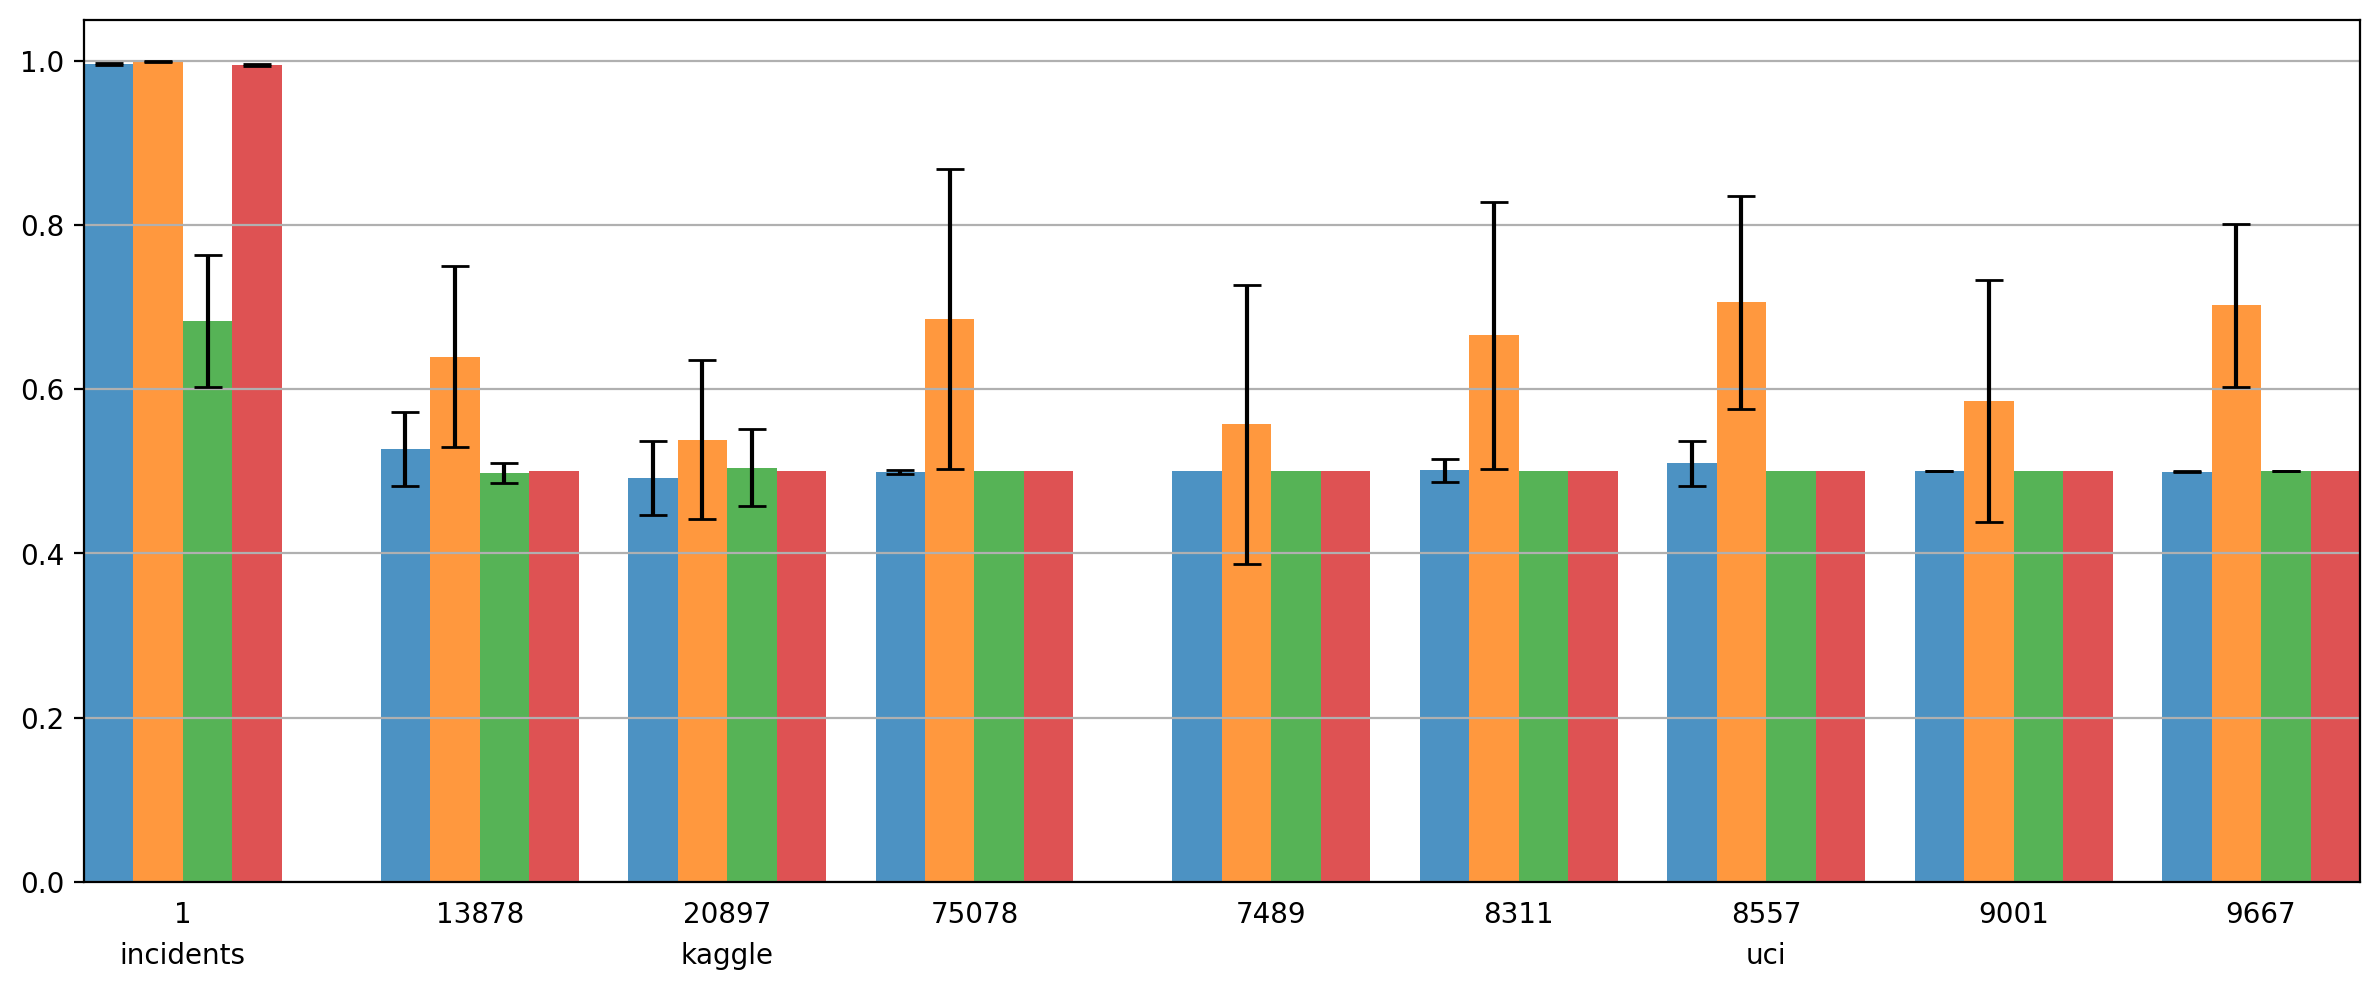

In [312]:
bar_width=0.1
increase=1.5
height=5

levels = [
    list(e) for e in df.index.levels
]
indices = [len(x) for x in levels]
colors = list(TABLEAU_COLORS.keys())

width = 120*bar_width
fig, axis = plt.subplots(figsize=(
    width,
    height
), dpi=200)

labels_offsets = {}
labels_index = {}
old_index = []
x = 0
for i, (index, (mean, std)) in enumerate(df["test_auroc"].iterrows()):
    if old_positions is None:
        old_positions = positions
    #for j, (new, old) in enumerate(reversed(list(zip(index, old_index))[:-1])):
    #    if new != old and old is not None or i+1==df.shape[0]:
    #        if j not in labels_offsets:
    #            labels_offsets[j] = 0
    #            labels_index[j] = 0
    #        labels_index[j] = i
    #        text_x = round((last_x + labels_offsets[j])/2, 4)
    #        print(round(last_x, 4), labels_offsets[j], text_x)
    #        axis.plot([text_x, text_x], [-0.25, 1])
    #        axis.text(
    #            text_x,
    #            -(j+1)/20,
    #            str(old_index[-j-2]).replace("_", "\n"),
    #            horizontalalignment='center'
    #        )
    #        updated_index.append(j)
    #        if i+1!=df.shape[0] and j!=len(index)-1:
    #            x += bar_width*increase**j/2
    
    jumps = [
        new != old or is_last(df, i)
        for j, (new, old) in enumerate(zip(index[:-1], old_index))
    ]
    
    for j, value in enumerate(jumps):
        if value:
            text_x = (
                x +
                (labels_offsets[j] if j in labels_offsets else 0) +
                (bar_width if is_last(df, i) else 0)
            )/2
            axis.text(
                text_x,
                (-len(jumps)+j)/20,
                old_index[j],
                horizontalalignment='center'
            )
    extra_space = sum(jumps)*bar_width*(not is_last(df, i))
    x = round(x + extra_space, 5)
    for j, value in enumerate(jumps):
        if value:
            labels_offsets[j] = x
    old_index = index
    axis.bar(
        x + bar_width/2,
        mean,
        **({"yerr": std} if std > 0 else {}),
        color=colors[list(levels[-1]).index(index[-1])],
        width=bar_width,
        capsize=5,
        alpha=0.8,
        label=index[-1]
    )
    x += bar_width

axis.yaxis.grid(True, which="both")
fig.tight_layout()
axis.set_xlim(0, x)
axis.set_xticks([])
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#axis.legend(by_label.values(), by_label.keys(), loc='best')
#axis.set_title(feature.replace("_", " ").capitalize())

#fig.savefig("{path}/{feature}.jpg".format(
#    path=path,
#    feature=feature
#))
